In [49]:
# Data Manipulation
#-----------------------------
import pandas as pd


# Data Visualisation
#-----------------------------
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image #Used to convert an image to a matrix

# Wordcloud library
from wordcloud import WordCloud

# Natural Laguage Processing
#-----------------------------
import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer


nltk.download('stopwords')


# Other packages
#-----------------------------
from collections import Counter # To create a dictionnary of word frequencies
import re
import string


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rigau\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Import files

We import the file created in the first section of the [NLP Preparation Notebook](./1%20-%20NLP%20Preparation.ipynb)


In [2]:
music = pd.read_csv('../Data/Processed Data/music_1_genre.csv', keep_default_na = False)

In [3]:
Genre_dict = {0:'Rock', 1:'Hip Hop', 2:'Pop'}
music['Genre'] = music['Genre'].map(Genre_dict)

# Data Preparation

We perform a similar preparation to the previous notebook, except we lemmatize the words, as opposed to stem them, for aesthetic purposes.

In [4]:
def regex_clean(txt, regex, sub=' '):
        
    return " ".join(re.sub(regex, sub, txt).split()) ## Substitute the desired regex with nothing,
                                                    ## then bring the sentence back together

In [5]:
lemmatizer = WordNetLemmatizer()
stpwrd = nltk.corpus.stopwords.words('english')
stpwrd.extend(string.punctuation)
stpwrd.extend(['chorus', 'verse', 'verses', 'choruses'])

In [6]:
def prep_data(lyrics):
    """ Cleans up a review!

    Parameters
    ----------
    review : string
        A text string that you want to parse and remove matches

    Returns
    -------
    Cleaned up string - tokenized & stemmed!
    """   
    
    ## Pre Token Cleaning - Stuff that applies to a string.
    
    lyrics = lyrics.lower()
    lyrics = regex_clean(lyrics, r'(\w)\1{2,}', r'\1') # Remove double letters (3 or more)
    lyrics = regex_clean(lyrics, r'(\W){2,}', r'\1') # Remove trailing punctuation
    lyrics = regex_clean(lyrics, r"'\s|'\.", r'g') # Replace trailing ' at the end of a word by g (eg. tryin' -> trying)
    lyrics = regex_clean(lyrics, r'(\[.*?\])', r'') # Remove [] and anything inside them (eg. [Chorus 2])
    lyrics = regex_clean(lyrics, r'\s\d+\s') # Remove digits

    ## Tokenize 
    lyrics = wordpunct_tokenize(lyrics)

    ## Post Token Cleaning - Stuff that applies to a list 

    lyrics = [lemmatizer.lemmatize(word) for word in lyrics]
    lyrics = [word for word in lyrics if word not in stpwrd]
    lyrics = [word for word in lyrics if len(word)>2]
    
    return lyrics

In [7]:
lyrics = [" ".join(prep_data(x)) for x in music['Lyric']]
music['clean lyric'] = lyrics

We save the cleaned data.

In [50]:
#music.to_csv('../Data/Processed Data/lemmatized_music.csv', index = False )

music = pd.read_csv('../Data/Processed Data/lemmatized_music.csv', keep_default_na = False)

# Visualisation Preparation

We import a custom font that will match the font used during the presentation.

In [51]:
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname='../Vis tools/Fonts/Raleway-Regular.ttf',
    name='Raleway')
fm.fontManager.ttflist.insert(0, fe) # or append is fine
matplotlib.rcParams['font.family'] = fe.name # = 'your custom ttf font name'

Custom colour palette, to match the presentation.

In [52]:
clrs = ['#93c47d', '#f4cccc', '#d9ead3', '#ea9999']

We define a function that will change the font, font size, colour and axis style of the graphs, again to fit the presentation better.

In [70]:
def ax_styling(ax, fsize = 12):
    
    '''This function takes in the ax object of a figure, and returns a stylised version of it.'''

   # Change the axis colour from black to dark grey
    ax.tick_params(axis='x', colors='#434343', labelsize = fsize)
    ax.tick_params(axis='y', colors='#434343', labelsize = fsize)

     # Change the labels' colour from black to dark grey
    ax.xaxis.label.set_color('#434343')
    ax.yaxis.label.set_color('#434343')
    
     # Change the labels' fontsize
    ax.xaxis.label.set_fontsize(fsize+2)
    ax.yaxis.label.set_fontsize(fsize+2)

    # Change the colour of the edge of the 'box' containing the figure.
    # The right and top edges will be white, the left and bottom edges will be dark grey.
    ax.spines['bottom'].set_color('#434343')
    ax.spines['left'].set_color('#434343')
    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    
    
    return ax


# Data Analysis

## Number of songs per genre

In [54]:
music.Genre.value_counts()

Rock       46125
Pop        21482
Hip Hop    11845
Name: Genre, dtype: int64

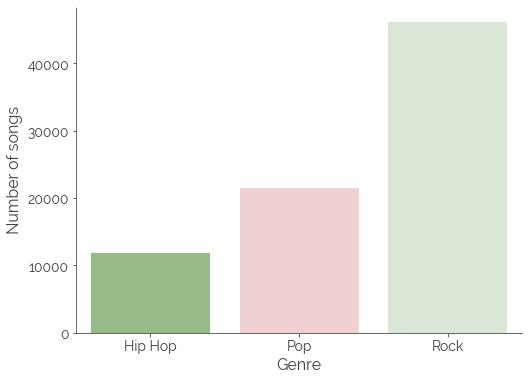

In [71]:

nb_songs = music.groupby(['Genre']).count()

fig, ax = plt.subplots(figsize=(8,6))

sns.barplot(x=nb_songs.index, y="SName", data=nb_songs, palette = clrs, ax=ax)
ax_styling(ax, fsize= 14)

ax.set_ylabel('Number of songs')


plt.show()

## Number of artists per genre

In [56]:
number_artists = music.groupby(['Genre'])[['Artist']].nunique()
number_artists

,Artist
Genre,
Hip Hop,148
Pop,370
Rock,505


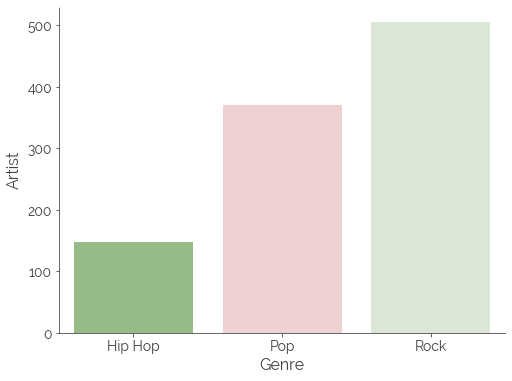

In [57]:

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=number_artists.index, y="Artist", data=number_artists, 
                           palette = clrs)

ax_styling(ax, fsize= 14)
plt.show()


# Average number of lyrics per genre

In [58]:
d = {'Genre': ['All','Hip Hop', 'Pop', 'Rock'], 
     'Average number of words': [music['clean lyric'].str.len().mean(),
                                music.loc[music.Genre == 'Hip Hop', 'clean lyric'].str.len().mean(),
                                music.loc[music.Genre == 'Pop', 'clean lyric'].str.len().mean(),
                                music.loc[music.Genre == 'Rock', 'clean lyric'].str.len().mean()]}

average_nb_lyrics = pd.DataFrame(data=d)

average_nb_lyrics.set_index('Genre', inplace=True)
average_nb_lyrics = average_nb_lyrics.astype(int)

In [59]:
average_nb_lyrics.head()

,Average number of words
Genre,
All,729
Hip Hop,1367
Pop,730
Rock,565


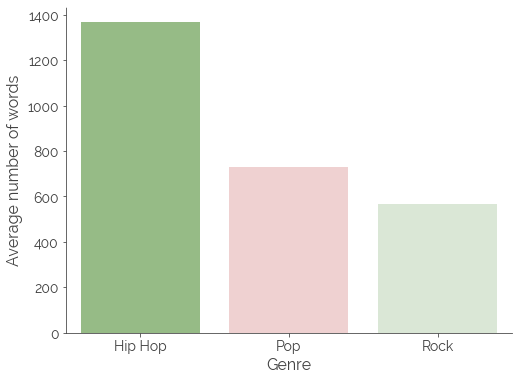

In [60]:
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=average_nb_lyrics.iloc[1:].index, y="Average number of words",
                           data=average_nb_lyrics.iloc[1:], palette = clrs)
ax_styling(ax, fsize= 14)
plt.show()

Hip Hop has the highest number of words.

# Word Cloud and word frequency

In [61]:
def make_cloud(frequencies,mask_path, width = 800, height = 400, size = (14,14), seed = 2):
    
    '''This function takes in a series, a mask path (to give the wordcloud a shape) and optional arguments for the size 
    of the cloud. The 'seed' arguments helps controlling the colours of the cloud.
    
    The function returns a wordcloud.
    
    Note: all masks are located in the folder with the following path: ./Visualisation/Mask/'''
    
    mask = np.array(Image.open(mask_path))
    
    wc = WordCloud(width=width, height=height, max_words=400,background_color="white", 
               mask = mask, 
               font_path = '../Vis tools/Fonts/Staatliches.ttf', #custom font
               contour_width=0, contour_color='silver',
               colormap = 'PiYG', 
                repeat=True, #Repeat the same word with different frequencies (used with the Hip Hop genre, were many words
                               #were changed to 'explicit'
              random_state = seed).generate_from_frequencies(frequencies)
    
    plt.figure(figsize=size)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

## All Genres

In [62]:
lyrics_counts = Counter()
music['clean lyric'].str.split().apply(lyrics_counts.update); #Create a dictionary containing the words frequency.

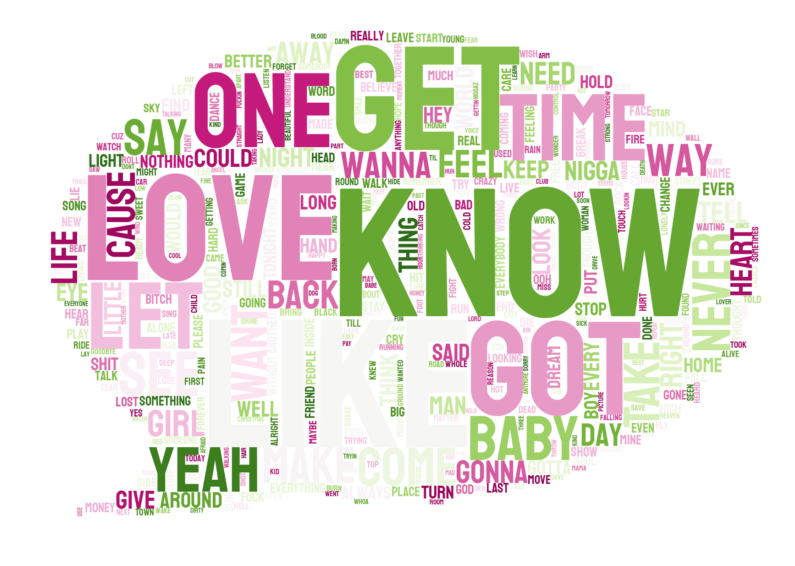

In [23]:
make_cloud(lyrics_counts,'../Vis tools/Masks/comment.png', seed = 4)

## Per music genre

In [34]:
def freq_to_df(music_genre):
    
    '''This function takes in a music genre and return the words frequency in a dataframe'''
    
    lyrics_counts = Counter()
    
    music.loc[music.Genre == music_genre, 'clean lyric'].str.split().apply(lyrics_counts.update)
    
    df = pd.DataFrame.from_dict(dict(lyrics_counts),orient='index', columns = ['Frequency'])
    df.sort_values(by=['Frequency'], ascending = False, inplace = True)
    
    return df

We create three dataframes, containing the words frequency for each genre.

In [36]:
hip_hop = freq_to_df('Hip Hop')
rock = freq_to_df('Rock')
pop = freq_to_df('Pop')

## Hip Hop songs

We remove the top 200 words from the rock and pop genres.

In [37]:
hip_hop_only = hip_hop[~hip_hop.index.isin(rock.iloc[:200].index) & ~hip_hop.index.isin(pop.iloc[:200].index)].copy()

We prepare a list of words to censor.

In [38]:
explicit = ['nigga','shit','bitch', 'fuck', 'niggaz', 'hoe', 'fuckin', 'motherfucker', 'dick', 'hook','fucking']

We add a column containing the censord words, as we will use that for our word cloud.

In [39]:
hip_hop_only.insert(0, 'censored', hip_hop_only.index.tolist())

All the words present in the 'explicit' list will now be censored and appear as 'Explicit' instead.

In [40]:
hip_hop_only.loc[hip_hop_only.censored.isin(explicit), 'censored'] = 'Explicit'

We sort the words frequency by descending order.

In [41]:
hip_hop_only.sort_values(by=['Frequency'], ascending=False, inplace=True)

Word cloud creation:

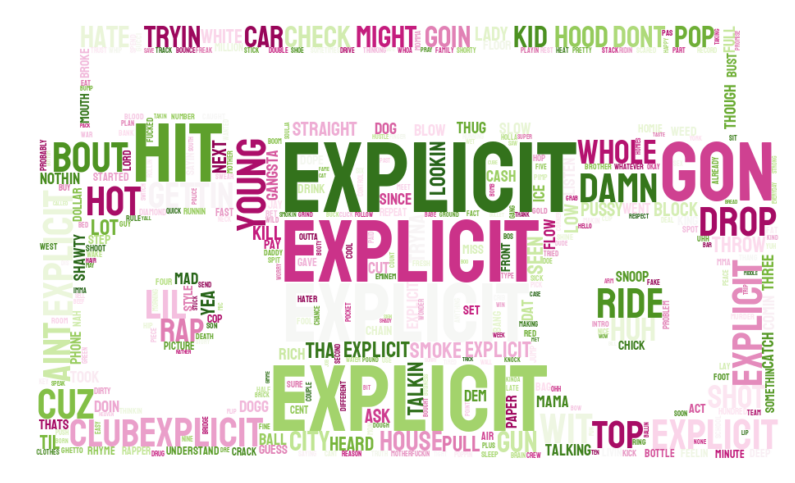

In [43]:
make_cloud(hip_hop_only[['censored','Frequency']].set_index('censored').Frequency, '../Vis tools/Masks/boombox.png')

## Rock songs

We perform the same operation as for the hip hop genre (minus the censure).
We remove the top 200 words from the Hip Hop and Pop genres.

We then create a word cloud.

In [44]:
rock_only = rock[~rock.index.isin(hip_hop.iloc[:200].index) & ~rock.index.isin(pop.iloc[:200].index)]

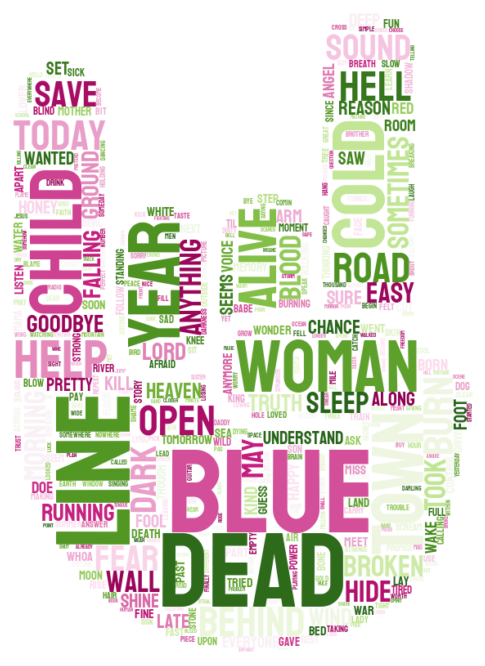

In [45]:
make_cloud(rock_only.Frequency, '../Vis tools/Masks/rock.png', size = (12,12))

## Pop songs

Again, we remove the top 200 words, but for the Hip Hop and Rock genres this time.

We then generate a word cloud.

In [46]:
pop_only = pop[~pop.index.isin(rock.iloc[:200].index) & ~pop.index.isin(hip_hop.iloc[:200].index)]

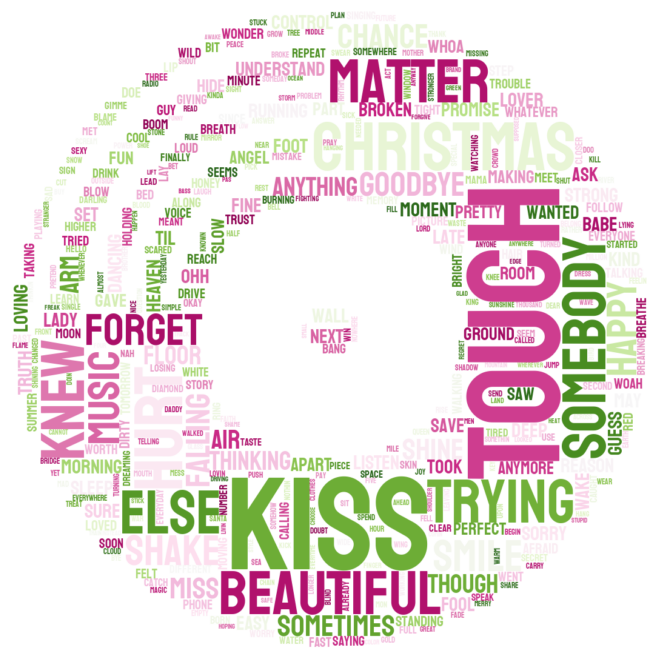

In [47]:
make_cloud(pop_only.Frequency, '../Vis tools/Masks/pop.png', size = (12,12), seed =3)